# Monte Carlo Profile Confidence Intervals for Dynamic Systems
    E Ionides, C. Breto, J Park, R. A. Smith, A. A. King

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

import os


In [62]:
R0    = 3
gamma = 1/7
beta  = R0*gamma
N     = 1e8

beta_truth  = beta
gamma_truth = f

priors_range_dict  = {}
priors_range_dict["beta"]  = [0.3, 1] # Contact rate
priors_range_dict["gamma"] = [1/10, 1/3]  # Recovery rate range

beta_search   = np.arange(priors_range_dict["beta"][0], priors_range_dict["beta"][1], 0.02)
gamma_search  = np.arange(priors_range_dict["gamma"][0], priors_range_dict["gamma"][1], 0.02)


In [63]:
log_lik = np.load(os.path.join( 'likelihood_surface.npz'))["loglik_array"]
log_lik.shape

loglik_df = []
for idx_beta, beta in enumerate(beta_search):
    for idx_gamma, gamma in enumerate(gamma_search):
        th_df =  pd.DataFrame(columns=["value", "ens_id", "beta", "gamma"])
        th_df["value"]  = -log_lik[idx_beta, idx_gamma, :].copy()
        th_df["ens_id"] = list(range(len(th_df)))
        th_df["beta"]   = beta
        th_df["gamma"]  = gamma
        loglik_df.append(th_df)

loglik_df = pd.concat(loglik_df)
loglik_df = loglik_df.groupby(["beta", "gamma"]).mean()[["value"]].reset_index()

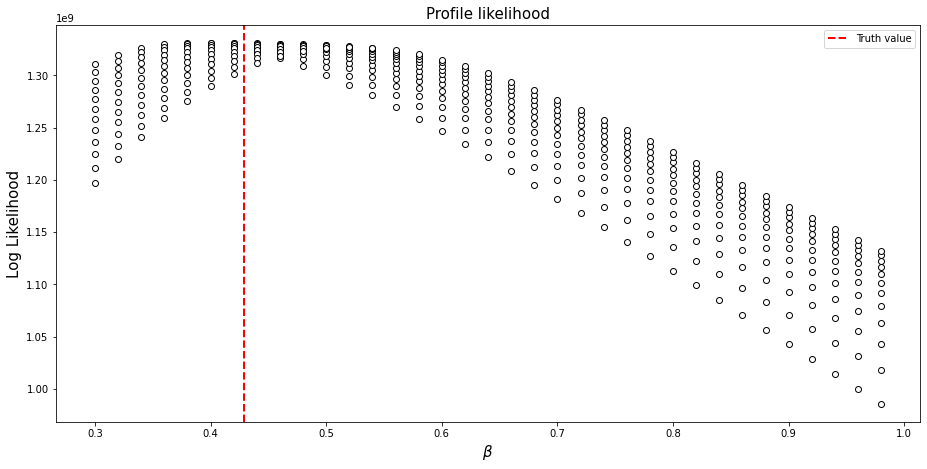

In [140]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.3))

ax.scatter(loglik_df.beta, -loglik_df.value, edgecolor="k", facecolor="white")
#sns.scatterplot(ax=ax, data=loglik_df, x="beta", y="value", hue="gamma", facecolor="white", edgecolor="k")

ax.axvline(x=beta_truth, color="red", linestyle="--", lw=2, label="Truth value")
ax.set_xlabel(r"$\beta$", fontsize=15)
ax.set_ylabel("Log Likelihood", fontsize=15)
ax.set_title("Profile likelihood", fontsize=15)
ax.legend()

In [244]:

from statsmodels.formula.api import wls
import statsmodels.api as sm

from scipy.stats import chi2 as qchisq

from scipy import linalg
from math import ceil
import numpy as np


def mcap_loglikelihood(loglik_values, param_search, confidence=0.95, lambda_sm=0.9, n_grid=1000):
    df_data       = pd.DataFrame(columns=["lp", "b", "a"])
    df_data["lp"] = loglik_values
    df_data["b"]  = param_search
    df_data["a"]  = param_search**2

    lowess_sm  = sm.nonparametric.lowess
    param_grid =  np.linspace(min(param_search), max(param_search), n_grid)
    loglik_sm  = lowess_sm(loglik_values, param_search, frac=1-lambda_sm, it=3, return_sorted = False, xvals=param_grid)

    arg_max   = np.argmin(loglik_sm)

    disttance = abs(param_search-param_grid[arg_max])

    #included <- dist < sort(dist)[trunc(lambda*length(dist))]

    max_dist  = np.max(disttance)

    weights = np.full( len(param_search), np.nan)
    weights = (1-(disttance/max_dist)**3)**3
    weights = {param_search[idx_p]: weights[idx_p] for idx_p in range(weights.shape[0])}
    #weights[included] <- (1-(dist[included]/maxdist)^3)^3

    df_data["weights"] = df_data["b"].replace(weights)

    model = wls(formula = 'lp ~ a + b', data = df_data, weights=df_data["weights"].values).fit()

    b      = model.params["b"]
    a      = model.params["a"]

    var_a  = model.cov_params().loc["a"]["a"]
    var_b  = model.cov_params().loc["a"]["a"]
    cov_ab = model.cov_params().loc["a"]["b"]

    se_mc_squared    = (1 / (4 * a**2)) * (var_b - (2 * b/a) * cov_ab + (b**2 / a**2) * var_a)
    se_stat_squared  = 1/(2*a)
    se_total_squared = se_mc_squared + se_stat_squared
    loglik_diff      = min(loglik_sm) -  loglik_sm

    delta            = qchisq.ppf(confidence, 1) * (a * se_mc_squared + 0.5)
    ci               = param_grid[np.where(loglik_diff > delta)]
    if ci.shape[0]>0:
        ci_low           = ci[0]
        ci_high          = ci[-1]
    else:
        ci_low           = None
        ci_high          = None

    confidence = int(confidence*100)
    df_param_resume                       = pd.DataFrame(columns=["mle", "delta", f"{confidence}_high", f"{confidence}_low"])
    df_param_resume["mle"]                = [param_grid[arg_max]]
    df_param_resume["delta"]              = [delta]
    df_param_resume[f"{confidence}_high"] = [ci_high]
    df_param_resume[f"{confidence}_low"]  = [ci_low]

    df_resume = pd.DataFrame(columns=["parameter", "loglik_smooth", "quadratic"])
    df_resume["parameter"]     = param_grid
    df_resume["loglik_smooth"] = loglik_sm
    df_resume["quadratic"]     = a * param_grid**2 + b * param_grid + model.params["Intercept"]

    return df_resume, df_param_resume

In [245]:
beta_df, beta_ci_df = mcap_loglikelihood(loglik_df.value, loglik_df.beta, confidence=0.95, lambda_sm=0.9, n_grid=1000)


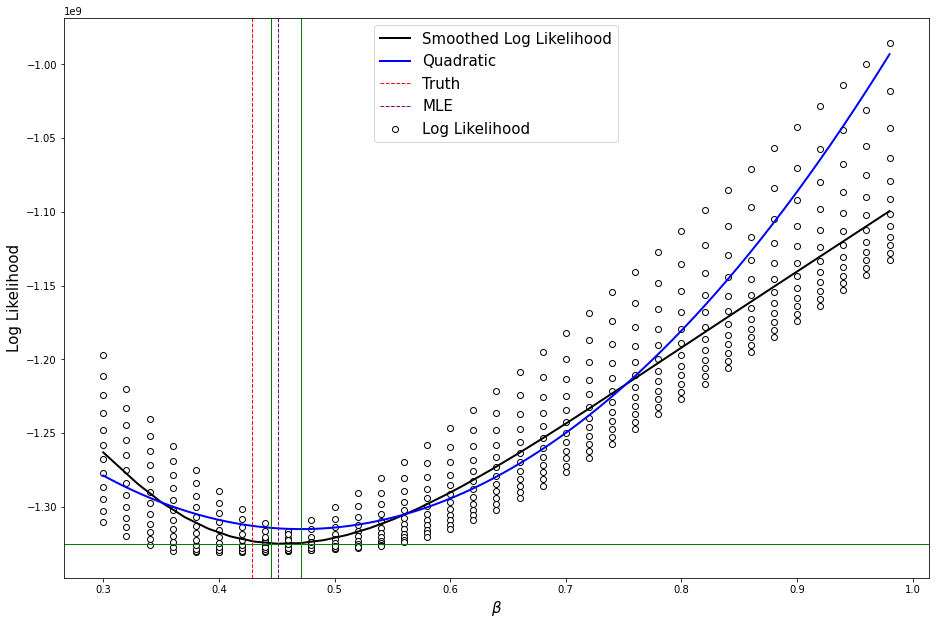

In [246]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(15.5, 10.3))

ax.scatter(loglik_df.beta, loglik_df.value, edgecolor="k", facecolor="white", label="Log Likelihood")
ax.plot(beta_df.parameter, beta_df.loglik_smooth, color="black", label = "Smoothed Log Likelihood", lw=2)
ax.plot(beta_df.parameter, beta_df.quadratic, color="blue", label = "Quadratic", lw=2)

ax.axvline(x=beta_ci_df["95_high"].values, color="green", linestyle="-", lw=1)
ax.axvline(x=beta_ci_df["95_low"].values, color="green", linestyle="-", lw=1)
ax.axhline(y=min(beta_df.loglik_smooth), color="green", linestyle="-", lw=1)
ax.axhline(y=min(beta_df.loglik_smooth)+beta_ci_df["delta"].values, color="green", linestyle="-", lw=1)

ax.axvline(x=beta_truth, color="red", linestyle="--", lw=1, label="Truth")
ax.axvline(x=beta_ci_df["mle"].values, color="purple", linestyle="--", lw=1, label="MLE")

ax.set_xlabel(r"$\beta$", fontsize=15)
ax.set_ylabel("Log Likelihood", fontsize=15)
ax.legend(fontsize=15)


In [255]:
gamma_df, gamma_ci_df = mcap_loglikelihood(loglik_df.value, loglik_df.gamma, confidence=0.95, lambda_sm=0.5, n_grid=1000)
gamma_df


,parameter,loglik_smooth,quadratic
0,0.100000,-1.212262e+09,-1.210658e+09
1,0.100220,-1.212361e+09,-1.210755e+09
2,0.100440,-1.212460e+09,-1.210852e+09
3,0.100661,-1.212559e+09,-1.210949e+09
4,0.100881,-1.212658e+09,-1.211046e+09
...,...,...,...
995,0.319119,-1.257525e+09,-1.255363e+09
996,0.319339,-1.257531e+09,-1.255355e+09
997,0.319560,-1.257538e+09,-1.255348e+09
998,0.319780,-1.257544e+09,-1.255340e+09


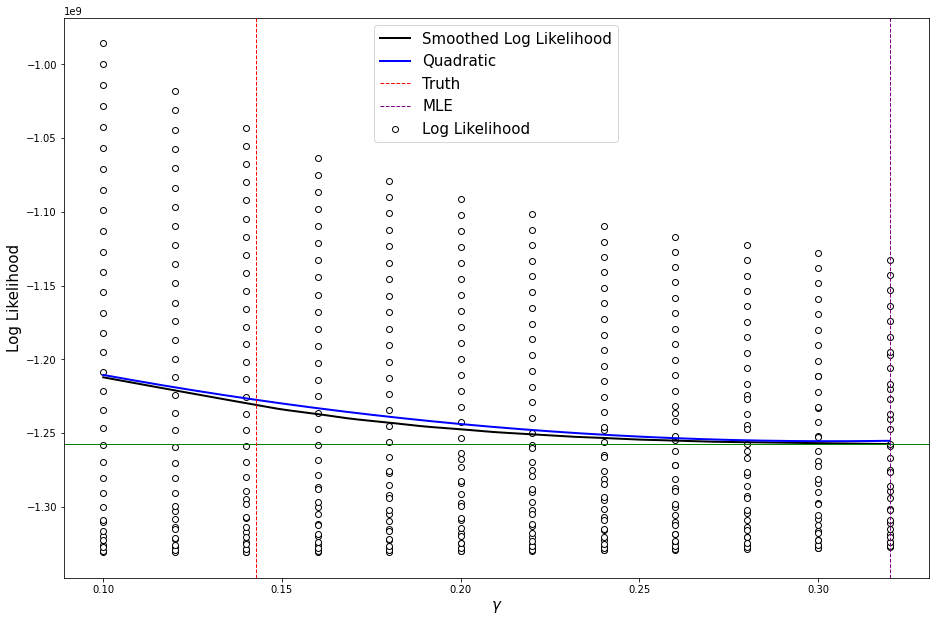

In [260]:

fig, ax = plt.subplots(1, 1, figsize=(15.5, 10.3))

ax.scatter(loglik_df.gamma, loglik_df.value, edgecolor="k", facecolor="white", label="Log Likelihood")
ax.plot(gamma_df.parameter, gamma_df.loglik_smooth, color="black", label = "Smoothed Log Likelihood", lw=2)
ax.plot(gamma_df.parameter, gamma_df.quadratic, color="blue", label = "Quadratic", lw=2)

#ax.axvline(x=gamma_ci_df["95_high"].values, color="green", linestyle="-", lw=1)
#ax.axvline(x=gamma_ci_df["95_low"].values, color="green", linestyle="-", lw=1)
ax.axhline(y=min(gamma_df.loglik_smooth), color="green", linestyle="-", lw=1)
#ax.axhline(y=min(gamma_df.loglik_smooth)+gamma_ci_df["delta"].values, color="green", linestyle="-", lw=1)

ax.axvline(x=gamma_truth, color="red", linestyle="--", lw=1, label="Truth")
ax.axvline(x=gamma_ci_df["mle"].values, color="purple", linestyle="--", lw=1, label="MLE")

ax.set_xlabel(r"$\gamma$", fontsize=15)
ax.set_ylabel("Log Likelihood", fontsize=15)
ax.legend(fontsize=15)
